<a href="https://colab.research.google.com/github/chavgova/Brain/blob/main/EEG_13_normalized_left_right.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import codecs
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from matplotlib import pyplot as plt
import math
import numpy as np
from keras.models import model_from_json
from keras.utils.vis_utils import plot_model
from scipy import signal
import scipy.io as scio
import pandas as pd
from scipy.signal import hilbert
from tensorflow.keras.layers import Flatten
from sklearn.utils import shuffle

In [ ]:
dataset_folder_path = '/content/drive/MyDrive/Brain/EEG_data/Bands/'
model_path = '/content/drive/MyDrive/Brain/EEG_Models/'
model_name = 'EEG_13_normalized_left-right'
channels_list = ['f3', 'f4','c3','c4', 'p3', 'p4']  # file names format 'c3_input_alpha.txt'
values_per_file = 39000
values_per_split = 9750
fs = 256 # Hz
# object_num = 4
channel_num = len(channels_list)

# Creating the DATASET

In [ ]:
dataset_files_list = [] 
dataset_files_list = os.listdir(dataset_folder_path)

print(dataset_files_list)
object_num = len(dataset_files_list)

['eeg_bands_object_1_fear', 'eeg_bands_object_2_joy', 'eeg_bands_object_1_joy', 'eeg_bands_object_2_fear']


In [ ]:
label_list = []

for item in dataset_files_list:
  if 'joy' in item:
    label_list.append('joy')
  elif 'fear' in item:
    label_list.append('fear')
print(label_list)    

['fear', 'joy', 'joy', 'fear']


# fs=256 Hz
Theta - 4 - 7.5 Hz

Alpha - 8 - 13.5 Hz

Beta -  14 - 30 Hz

Gamma - 30.5 - 40 Hz

In [ ]:
def formatDataFromTXT(contents):
  contents_list = contents.splitlines()
  contents_array = np.array([])

  contents_array = np.array([float(a) for a in contents_list])
  a = int((contents_array.shape[0]-values_per_file)/2)
  contents_array = contents_array[a:-a]  ##############
  
  return contents_array 

def ReadObjectData(object_folder_name):
  object_data_3d = np.empty((channel_num, 4, values_per_file), float)  # object = (channels, bands, values) = (6, 4, values)
  i = 0 # channel counter
  for channel_name in channels_list:
    channel_data_2d = ReadChannelData(channel_name)
    object_data_3d[i] = channel_data_2d
    i+=1

  return object_data_3d

def ReadChannelData(channel_name):
  channel_data_2d = np.empty((4, values_per_file), float) # channel = (bands, values)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_alpha.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  alpha_data = formatDataFromTXT(contents)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_beta.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  beta_data = formatDataFromTXT(contents)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_gamma.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  gamma_data = formatDataFromTXT(contents)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_theta.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  theta_data = formatDataFromTXT(contents)
  channel_data_2d[0] = theta_data
  channel_data_2d[1] = alpha_data
  channel_data_2d[2] = beta_data
  channel_data_2d[3] = gamma_data

  return channel_data_2d

(objects, channels, bands, values) = (4, 6, 4, 40000)

In [ ]:
objects_data_4d = np.empty((object_num, channel_num, 4, values_per_file), float) # (objects, channels, bands, values) = (4, 6, 4, 40000)

j = 0 # object counter 

for object_folder_name in dataset_files_list:
  object_data_3d = ReadObjectData(object_folder_name)
  objects_data_4d[j] = object_data_3d
  j+=1

print(objects_data_4d)

[[[[ -0.50891707  -0.31027898  -0.10954685 ...   2.1283049
      2.0532411    1.9494225 ]
   [  1.5839479    2.1723225    2.6031686  ...  -8.1001747
     -8.3238203   -8.0164988 ]
   [  1.5323874    1.6039654    1.6474962  ...   0.31907498
      1.0598392    1.6268175 ]
   [  3.0686368    5.2220705    3.6802744  ...   1.8627944
      3.1573305    2.2529469 ]]

  [[  0.14809261  -0.29459613  -0.74608276 ...  -1.0638328
     -1.293974    -1.4826647 ]
   [  3.774685     3.8369945    3.6260285  ...  -7.1151362
     -7.2679148   -6.9321938 ]
   [  0.15039661   0.95121237   1.69713    ...   3.7197396
      3.0711639    2.269     ]
   [  5.511933     6.0545498    2.3823398  ...   3.4140475
      4.3508997    2.1711638 ]]

  [[  0.99851246   1.2463123    1.4635768  ...   2.403994
      2.3017453    2.1664624 ]
   [ -1.445182    -1.168948    -0.80276405 ...  -1.4480942
     -1.4844276   -1.43031   ]
   [ -0.47241475  -0.78637838  -0.85391767 ...   0.19982705
      0.70106691   0.93756382]
   [ 

In [ ]:
print(objects_data_4d.shape)
print(objects_data_4d[0, 0, 0, :]) # [0, 0, 0, :] == first object, c3 (first channel), theta band, values 

(4, 6, 4, 39000)
[-0.50891707 -0.31027898 -0.10954685 ...  2.1283049   2.0532411
  1.9494225 ]


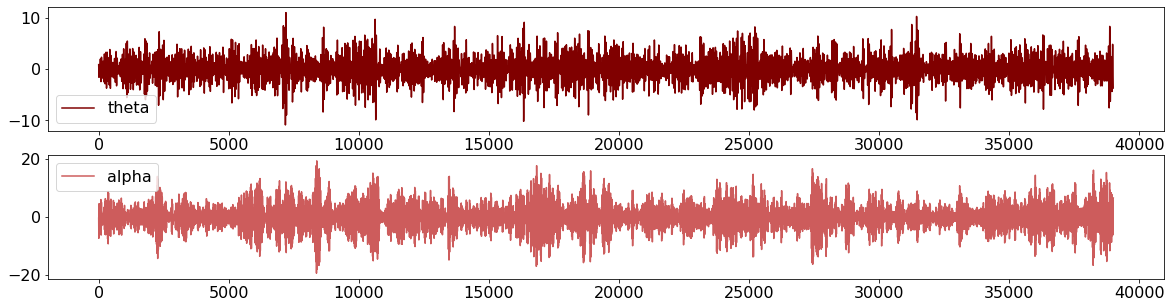

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d[2, 3, 0, :], label='theta', color='maroon')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d[2, 3, 1, :], label='alpha', color='indianred')
plt.legend()

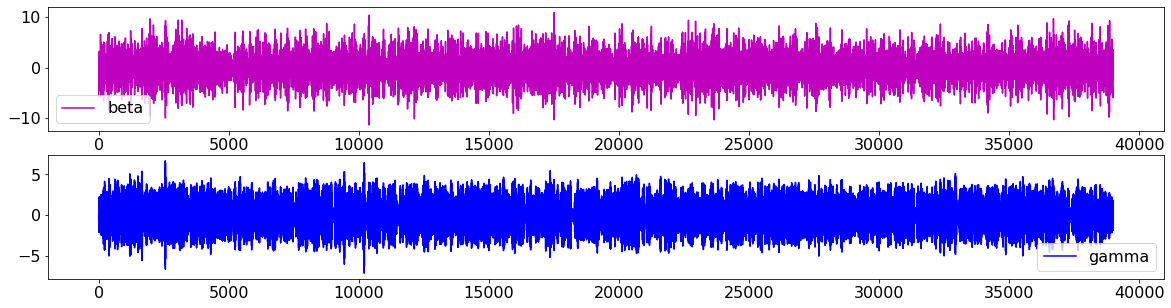

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d[2, 3, 2, :], label='beta', color='m')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d[2, 3, 3, :], label='gamma', color='b')
plt.legend()

(objects, channels, bands, values) = (4, 6, 4, 40000)

# **NORMALIZE**

In [ ]:
from sklearn import preprocessing

def StandardizeByChannel(data):
  objects_data_4d_scaled = np.empty((4, channel_num, 4, values_per_file), float)  # (objects, channels, bands, values) = (4, 6, 4, 40000)
  j = 0 # object counter
  i = 0 # channel counter
  for j in range(0,4):
    for i in range(0,6):
      objects_data_4d_scaled[j, i, :, :] = preprocessing.normalize(data[j, i, :, :])
      i+=1
    j+=1  

  return objects_data_4d_scaled

In [ ]:
objects_data_4d = StandardizeByChannel(objects_data_4d)

**SPLIT**

In [ ]:
objects_data_4d_split = np.zeros((int(object_num*values_per_file/values_per_split), channel_num, 4, values_per_split))
j = 0

for obj in range(0, object_num):
  i = 0

  while i < values_per_file:
      objects_data_4d_split[j] = objects_data_4d[obj,:,:,i:(i+values_per_split)]
      i+=values_per_split
      j+=1

print(objects_data_4d_split)      
print(objects_data_4d_split.shape) 

[[[[-9.59411116e-04 -5.84938333e-04 -2.06517863e-04 ... -2.67948391e-03
    -3.55550678e-03 -4.42242602e-03]
   [ 2.03413799e-03  2.78974058e-03  3.34304187e-03 ... -8.31255371e-03
    -7.21824279e-03 -5.62884722e-03]
   [ 2.33379244e-03  2.44280416e-03  2.50910062e-03 ...  1.19315972e-03
     1.35228983e-04 -2.12554057e-03]
   [ 5.28014447e-03  8.98551652e-03  6.33257755e-03 ...  6.62344040e-03
     6.38970932e-04 -5.80705582e-03]]

  [[ 2.78757991e-04 -5.54524802e-04 -1.40436806e-03 ... -2.86044403e-03
    -3.28480093e-03 -3.68206840e-03]
   [ 4.59382504e-03  4.66965625e-03  4.41290876e-03 ... -7.97221287e-03
    -6.89338151e-03 -5.41742020e-03]
   [ 2.44303131e-04  1.54514228e-03  2.75680531e-03 ...  2.30096941e-03
    -1.50623070e-03 -5.25244046e-03]
   [ 1.08790257e-02  1.19500006e-02  4.70207745e-03 ...  5.17306920e-03
    -5.36649083e-04 -5.62089734e-03]]

  [[ 2.70569014e-03  3.37715856e-03  3.96588473e-03 ... -9.00540426e-04
    -1.67516833e-03 -2.48234597e-03]
   [-3.48502099

'c3', 'c4', 'f3', 'f4', 'p3', 'p4'

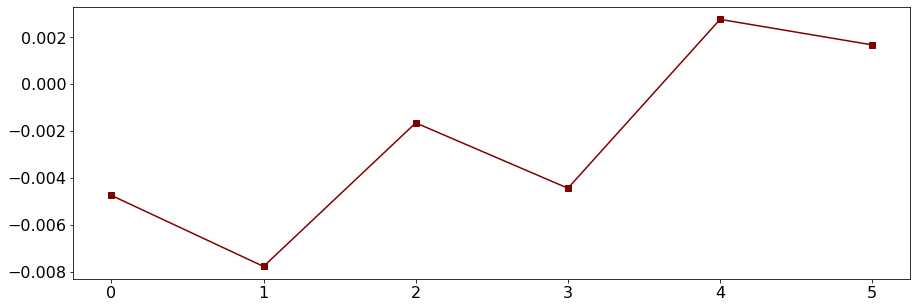

In [ ]:
b = np.array(objects_data_4d_split[1, :, 2, 0]) 
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(b, label='c3 - theta', color='maroon', marker='s')

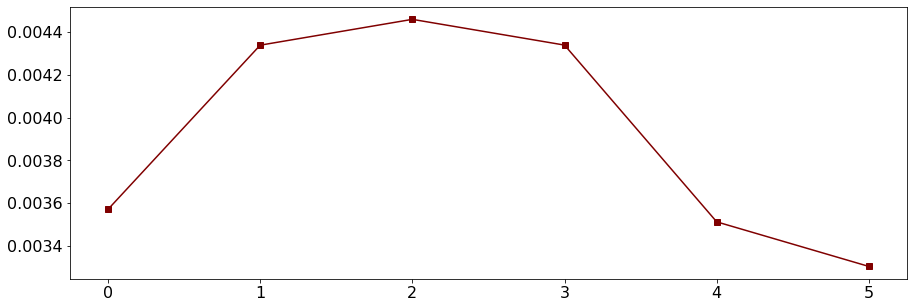

In [ ]:
b = np.array(objects_data_4d_split[5, :, 2, 0]) # joy

plt.rcParams["figure.figsize"] = (15,5)
plt.plot(b, label='c3 - theta', color='maroon', marker='s')

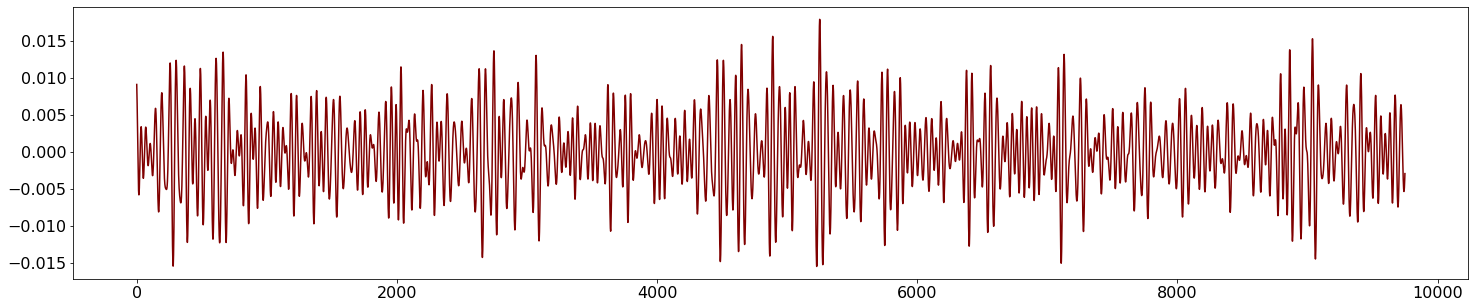

In [ ]:
b = np.array(objects_data_4d_split[10, 0, 0, :])

plt.rcParams["figure.figsize"] = (25,5)
plt.plot(b, label='c3 - theta', color='maroon')

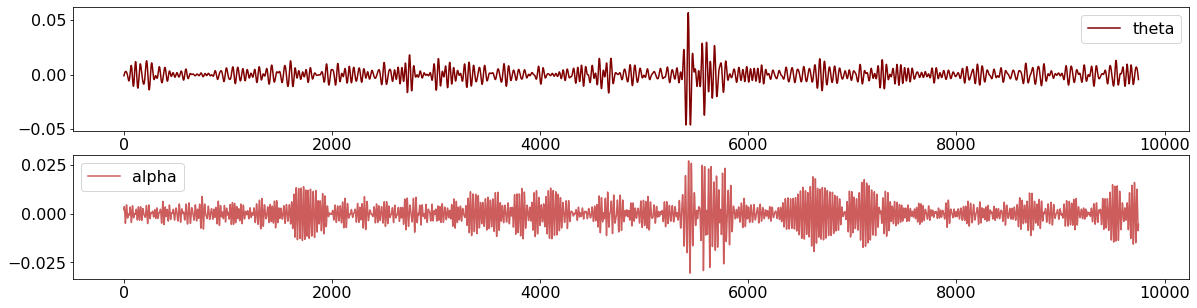

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d_split[0, 0, 0, :], label='theta', color='maroon')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d_split[0, 0, 1, :], label='alpha', color='indianred')
plt.legend()

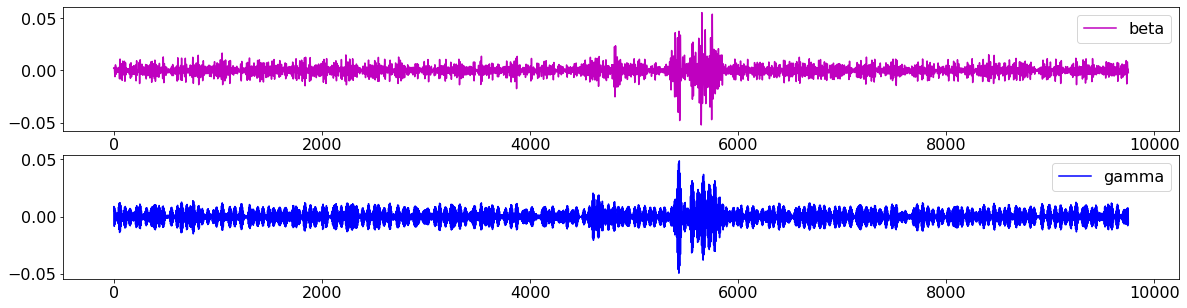

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d_split[0, 0, 2, :], label='beta', color='m')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d_split[0, 0, 3, :], label='gamma', color='b')
plt.legend()

In [ ]:
objects_data_4d_split[0,:,:,:].shape

(6, 4, 9750)

In [ ]:
np.var(objects_data_4d_split[2,:,:,:])

2.5740851186969267e-05

In [ ]:
label_list = [ item for item in label_list for repetitions in range(4) ]
label_list

['fear',
 'fear',
 'fear',
 'fear',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'fear',
 'fear',
 'fear',
 'fear']

In [ ]:
i=0
while i!=16:
  rat = np.var(objects_data_4d_split[i,:,:,:])/np.median(objects_data_4d_split[i,:,:,:])
  print(label_list[i], " -> ", rat)
  i+=1

fear  ->  -6.9742841466884
fear  ->  -12.382585122134996
fear  ->  2.6783383242571728
fear  ->  -6.550031025423206
joy  ->  -2.077640231749448
joy  ->  2.632584980635655
joy  ->  -10.627792508702575
joy  ->  -2.092828480957638
joy  ->  14.638680581017235
joy  ->  -4.596341904645076
joy  ->  -4.424374342657087
joy  ->  -2.780955251562275
fear  ->  1.3705285137712397
fear  ->  7.524348663215885
fear  ->  -68.81419483452507
fear  ->  5.714578008400073


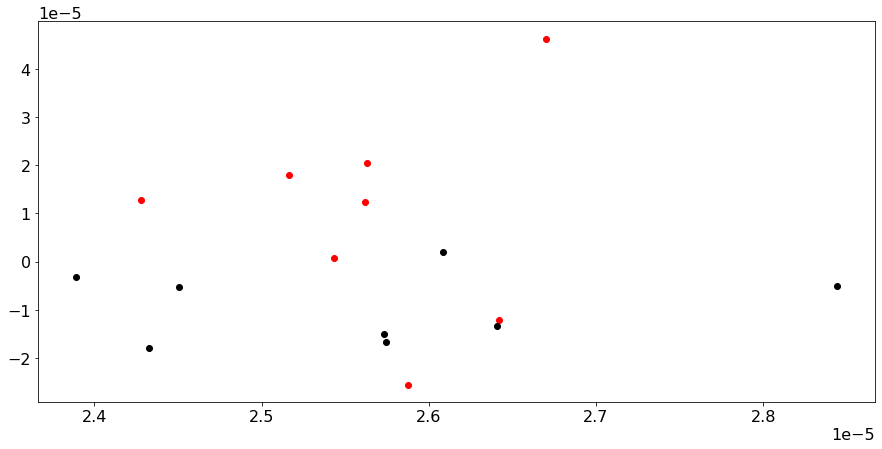

In [ ]:
plt.rcParams["figure.figsize"] = (15,7)
plt.rcParams.update({'font.size': 16})

x = np.array( [ np.var(item) for item in objects_data_4d_split[:4,3,3,:]])
y = np.array( [ np.median(item) for item in objects_data_4d_split[:4,3,3,:]])
plt.plot(x, y, 'o', color='black')
x = np.array( [ np.var(item) for item in objects_data_4d_split[4:12,3,3,:]])
y = np.array( [ np.median(item) for item in objects_data_4d_split[4:12,3,3,:]])
plt.plot(x, y, 'o', color='red')
x = np.array( [ np.var(item) for item in objects_data_4d_split[12:,3,3,:]])
y = np.array( [ np.median(item) for item in objects_data_4d_split[12:,3,3,:]])
plt.plot(x, y, 'o', color='black')


In [ ]:
x

array([2.60879788e-05, 2.43258434e-05, 2.64059344e-05, 2.57443441e-05])

Shuffle

In [ ]:
objects_data_4d_split, label_list = shuffle(objects_data_4d_split, label_list)
print(label_list)

['fear', 'fear', 'fear', 'joy', 'joy', 'fear', 'joy', 'fear', 'fear', 'joy', 'joy', 'joy', 'joy', 'fear', 'fear', 'joy']


np.save((model_path + 'DATA_objects_data_4d_split_right-left-3-4-10000'), objects_data_4d_split)

np.save((model_path + 'DATA_objects_data_4d_split_right-left-3-4-10000_label_list'), label_list)


objects_data_4d_split = np.load(model_path + 'DATA_objects_data_4d_split.npy')

label_list = np.load(model_path + 'DATA_label_list.npy')

In [ ]:
label_list_0or1 = []
for label in label_list:
  if label == 'joy':
    label_list_0or1.append(0.)
  elif label == 'fear':
    label_list_0or1.append(1.)
    
label_list_0or1 = np.array(label_list_0or1)
print(label_list_0or1)  

[1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.]


1 average value per 1000 values 

# EXTRACTION FUNCTION

In [ ]:
objects_data_4d_split_extract = np.zeros((int(object_num*values_per_file/values_per_split), channel_num, 4, 10))

for i in range(0, 16):
  for j in range(0, channel_num):
    for k in range(0, 4):
      for l in range(0,10):
        objects_data_4d_split_extract[i, j, k, l] = np.average(objects_data_4d_split[i, j, k, l*975:(l+1)*975])

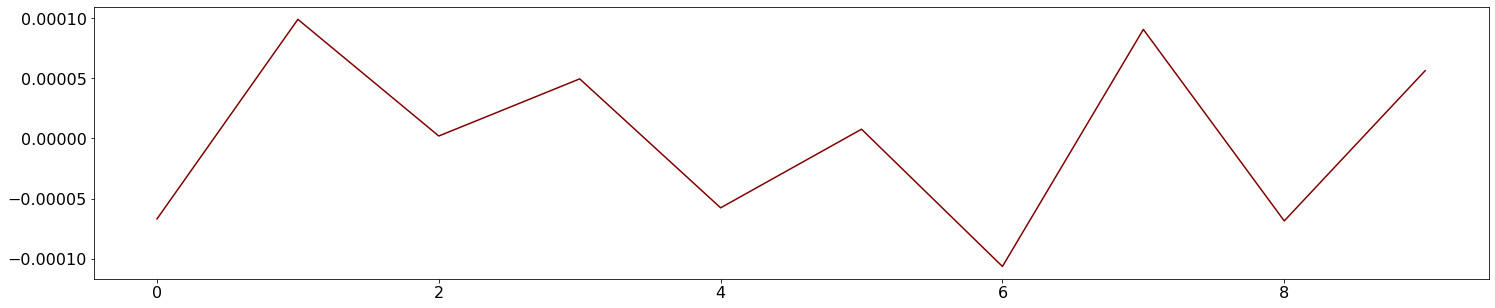

In [ ]:
b = np.array(objects_data_4d_split_extract[10, 0, 0, :])

plt.rcParams["figure.figsize"] = (25,5)
plt.plot(b, label='c3 - theta', color='maroon')

# RATIO - LEFT/RIGHT HEMISPHERE 

In [ ]:
def ChannelRatio(data):
  ratio_data = np.empty((16, int(channel_num/2), 4, 10), float)  # (objects, channels, bands, values) = (4, 6, 4, 40000)
  j = 0 # object counter
  i = 0 # channel counter
  for j in range(0,16):
    for i in range(0,6,2):
      for h in range(0,3):
        ratio_data[j, h, :, :] = np.divide(data[j, i, :, :], data[j, i+1, :, :])
        #print(j, i, h)

  return ratio_data

In [ ]:
objects_data_4d_split_extract_ratio = ChannelRatio(objects_data_4d_split_extract) 

# TRAIN / TEST 

In [ ]:
num_1 = 0
num_0 = 0
i = 0
index_list = []

while len(index_list)<4:
  if (label_list_0or1[i] == 0) and (num_0!=2):
    index_list.append(i)
    num_0+=1
  elif (label_list_0or1[i] == 1) and (num_1!=2): 
    index_list.append(i)
    num_1+=1
  i+=1
print(i)

5


In [ ]:
x_test = objects_data_4d_split_extract_ratio[index_list,:]
y_test = label_list_0or1[index_list]
print(y_test)

[1. 1. 0. 0.]


In [ ]:
x_test

array([[[[-1.52667535e+02,  8.55585872e-01, -4.72948975e-01,
           5.42985946e+00, -6.50661701e-02, -5.35111415e+00,
           1.16212043e+00, -2.29637282e+00, -1.07524996e+00,
          -1.49640206e-01],
         [ 4.97173778e+00,  7.48786764e+00,  2.94039235e+00,
           1.29901333e+00, -1.03125967e+00, -3.20309106e+00,
          -2.09743481e+01, -3.14530799e+00,  7.22205456e-01,
           1.65252615e+00],
         [-1.84499466e+00,  7.82387014e-02, -2.60828483e+00,
          -8.92949705e-02,  1.20874428e+00, -3.07304499e-01,
          -9.43165977e+00, -1.51848701e+00,  9.29150824e-01,
          -6.04690833e-01],
         [ 4.67819972e+01,  2.80054232e-01,  2.52070262e+00,
           8.10122656e+00,  8.17437862e-02, -7.08088137e-01,
          -2.13947747e+00, -6.01103810e-01,  5.91902073e+00,
          -2.30356398e-01]],

        [[-1.52667535e+02,  8.55585872e-01, -4.72948975e-01,
           5.42985946e+00, -6.50661701e-02, -5.35111415e+00,
           1.16212043e+00, -2.29

In [ ]:
x_train = np.delete(objects_data_4d_split_extract_ratio, index_list, 0)
y_train = np.delete(label_list_0or1, index_list)
print(x_train.shape)

(12, 3, 4, 10)


Reshape Data

In [ ]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1,1))

In [ ]:
y_train

array([[[1.]],

       [[1.]],

       [[0.]],

       [[1.]],

       [[1.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[1.]],

       [[1.]],

       [[0.]]], dtype=float32)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='tanh', input_shape=(int(channel_num/2), 4, 10)))
#model.add(Conv2D(16, (2,2), activation='tanh'))
#model.add(Flatten())
#model.add(Dense(64, activation='tanh', input_shape=(int(channel_num/2), 4, 10)))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 2, 32)          2912      
                                                                 
 dense (Dense)               (None, 1, 2, 32)          1056      
                                                                 
 dense_1 (Dense)             (None, 1, 2, 16)          528       
                                                                 
 dense_2 (Dense)             (None, 1, 2, 8)           136       
                                                                 
 dense_3 (Dense)             (None, 1, 2, 1)           9         
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


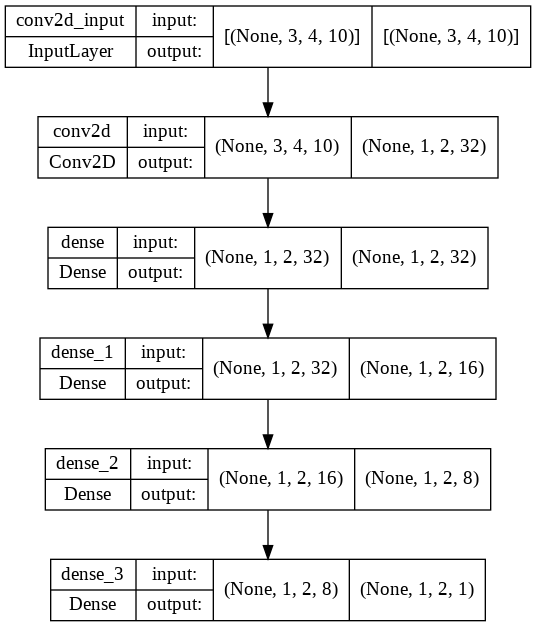

In [ ]:
plot_model(model, to_file=(model_path+'NNmodel_plot.png'), show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(x_train, y_train, epochs=200, batch_size=4, validation_data = (x_test, y_test))

Epoch 1/200
3/3 [==============================] - 1s 104ms/step - loss: 0.7404 - accuracy: 0.5000 - val_loss: 0.7545 - val_accuracy: 0.1250
Epoch 2/200
3/3 [==============================] - 0s 13ms/step - loss: 0.6159 - accuracy: 0.6250 - val_loss: 0.6962 - val_accuracy: 0.2500
Epoch 3/200
3/3 [==============================] - 0s 13ms/step - loss: 0.5330 - accuracy: 0.8333 - val_loss: 0.6830 - val_accuracy: 0.5000
Epoch 4/200
3/3 [==============================] - 0s 14ms/step - loss: 0.4656 - accuracy: 0.9167 - val_loss: 0.6730 - val_accuracy: 0.5000
Epoch 5/200
3/3 [==============================] - 0s 14ms/step - loss: 0.4081 - accuracy: 0.9167 - val_loss: 0.6599 - val_accuracy: 0.5000
Epoch 6/200
3/3 [==============================] - 0s 15ms/step - loss: 0.3639 - accuracy: 0.9167 - val_loss: 0.6455 - val_accuracy: 0.5000
Epoch 7/200
3/3 [==============================] - 0s 16ms/step - loss: 0.3214 - accuracy: 0.9583 - val_loss: 0.6315 - val_accuracy: 0.6250
Epoch 8/200
3/3 [==

In [ ]:
_, accuracy = model.evaluate(x_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1/1 [==============================] - 0s 245ms/step - loss: 0.7876 - accuracy: 0.7500
Accuracy: 75.00


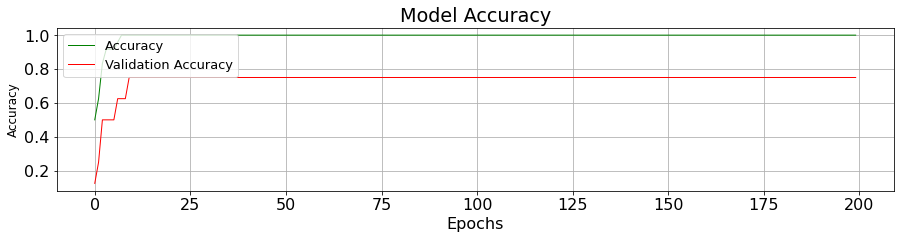

In [ ]:
plt.figure(figsize=(15,3), frameon=True)
plt.rcParams.update({'font.size': 16})

plt.plot(history.history['accuracy'], 'g', linewidth=1)
plt.plot(history.history['val_accuracy'], 'r', linewidth=1)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy', fontsize=12)
plt.legend(['Accuracy', 'Validation Accuracy'], loc = 'upper left', fontsize=13)
plt.grid(True)
plt.show()

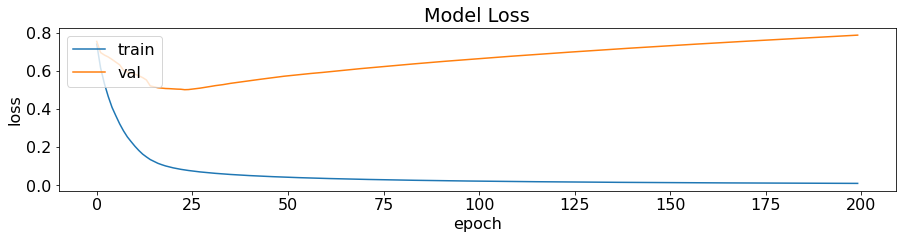

In [ ]:
plt.figure(figsize=(15,3), frameon=True)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<Figure size 1080x360 with 0 Axes>

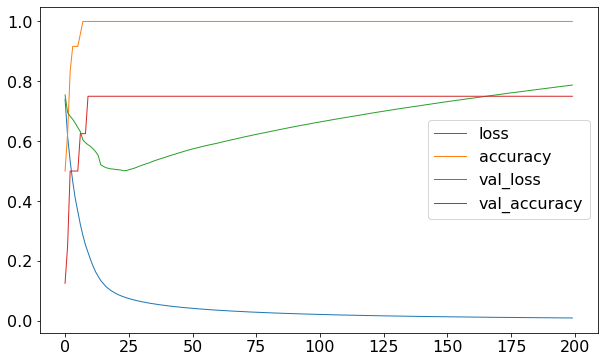

In [ ]:
plt.figure(figsize=(15,5), frameon=True)
pd.DataFrame(history.history).plot(figsize=(10,6),linewidth=1)
plt.show()

In [ ]:
model.save(os.path.join(model_path, (model_name + '_MODEL.h5')))
print('Saved trained model at %s ' % model_path)

model_json = model.to_json()
with open((model_path + model_name + '_MODEL.json'), "w") as json_file:
    json_file.write(model_json)

In [ ]:
json_file = open(model_path + model_name + '_MODEL.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(model_path + model_name + '_MODEL.h5')
print("Loaded model from disk")

opt = tf.keras.optimizers.Adam(learning_rate=0.0001) 
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])